<BarContainer object of 4 artists>

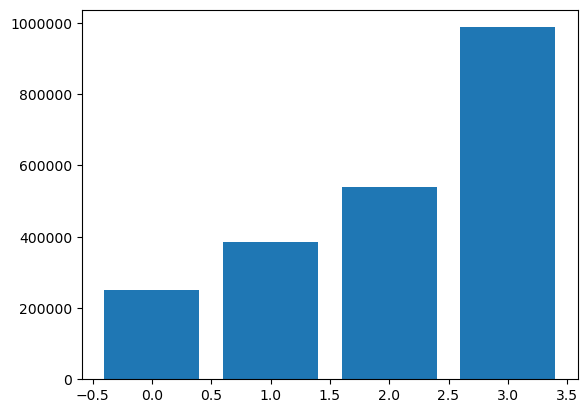

In [1]:
# 1. Qual a média do preço de compra dos imóveis por "Nível"?
#          - Nível 0 -> Preço entre R$0 e R$321.950
#          - Nível 1 -> Preço entre R$321.950 e R$450.000
#          - Nível 2 -> Preço entre R$450.000 e R$645.000
#          - Nível 3 -> Acima de R$645.000
import pandas as pd
from matplotlib import pyplot

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data = pd.read_csv('datasets/kc_house_data.csv')
data['level'] = data['price'].apply(lambda price: 0 if price <= 321950 else 1 if price <= 450000 else 2 if price <= 645000 else 3)

chart_data = data[['price', 'level']].groupby('level').mean().reset_index()
pyplot.ticklabel_format(style='plain')  # Avoid scientific notation of being used.
pyplot.bar(chart_data['level'], chart_data['price'])

<BarContainer object of 4 artists>

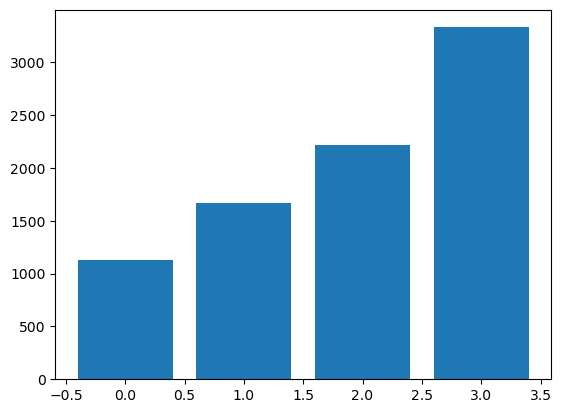

In [2]:
# 2. Qual a média do tamanho da sala de estar dos imóveis por "Size"?
#          - Size 0 -> Tamanho entre 0 e 1427 sqft
#          - Size 1 -> Tamanho entre 1427 e 1910 sqft
#          - Size 2 -> Tamanho entre 1910 e 2550 sqft
#          - Size 3 -> Acima de 2550 sqft

import pandas as pd
from matplotlib import pyplot

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data = pd.read_csv('datasets/kc_house_data.csv')

data['living_room_size'] = data['sqft_living'].apply(lambda sqft_living: 0 if sqft_living <= 1427 else 1 if sqft_living <= 1910 else 2 if sqft_living <= 2550 else 3)
chart_data = data[['sqft_living', 'living_room_size']].groupby('living_room_size').mean().reset_index()
pyplot.ticklabel_format(style='plain')
pyplot.bar(chart_data['living_room_size'], chart_data['sqft_living'])

In [3]:
# 3. Adicione as seguintes informações ao conjunto de dados original:
#          - Place ID: Identificação de localização
#          - OSM Type: Open Street Map type
#          - Country: Nome do País
#          - Country Code: Código do País
import pandas as pd
from geopy.geocoders import Nominatim

data = pd.read_csv('datasets/kc_house_data.csv')
geo_locator = Nominatim(user_agent='geo_agent')

for i in range(len(data)):
    resp = geo_locator.reverse(f'{data.loc[i, "lat"]},{data.loc[i, "long"]}')
    data.loc[i, 'place_id'] = resp.raw['place_id']
    data.loc[i, 'osm_type'] = resp.raw['osm_type']
    data.loc[i, 'country'] = resp.raw['address']['country']
    data.loc[i, 'country_code'] = resp.raw['address']['country_code']
data.head(10)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=47.2809&lon=-122.296&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [4]:
# 4. Adicione os seguintes filtros no mapa:
#          - Tamanho mínimo da área da sala de estar
#          - Número mínimo de banheiros
#          - Valor máximo do preço
#          - Tamanho máximo da área do porão
#          - Filtro das condições do imóvel
#          - Filtro por ano de construção

import pandas as pd
import ipywidgets as pywid
from plotly import express as exp

data = pd.read_csv('datasets/kc_house_data.csv')

style = {
    'description_width': 'initial'
}

### Widgets. 
# Tamanho minimo da area da sala de estar.
min_sqft_living, max_sqft_living = data['sqft_living'].min(), data['sqft_living'].max()
sqft_living_slider = pywid.IntSlider(
    value=(min_sqft_living + max_sqft_living) / 2,
    min=min_sqft_living,
    max=max_sqft_living,
    step=1,
    description='Sqft living',
    disable=False,
    style=style
)

# Numero minimo de banheiros.
min_bedrooms, max_bedrooms = data['bedrooms'].min(), data['bedrooms'].max()
bedrooms_slider = pywid.IntSlider(
    value=(min_bedrooms + max_bedrooms) / 2,
    min=min_bedrooms,
    max=max_bedrooms,
    step=1,
    description='Bedrooms',
    disable=False,
    style=style
)

# Valor máximo do preço.
min_price, max_price = data['price'].min(), data['price'].max()
price_slider = pywid.IntSlider(
    value=(min_price + max_price) / 2,
    min=min_price,
    max=max_price,
    step=1,
    description='Price $',
    disable=False,
    style=style
)

# Tamanho máximo da área do porão.
min_sqft_basement, max_sqft_basement = data['sqft_basement'].min(), data['sqft_basement'].max()
sqft_basement_slider = pywid.IntSlider(
    value=(min_sqft_basement + max_sqft_basement) / 2,
    min=min_sqft_basement,
    max=max_sqft_basement,
    step=1,
    description='Sqft basement',
    disable=False,
    style=style
)

# Filtro das condições do imóvel.
min_condition, max_condition = data['condition'].min(), data['condition'].max()
condition_slider = pywid.IntSlider(
    value=(min_condition + max_condition) / 2,
    min=min_condition,
    max=max_condition,
    step=1,
    description='Condition',
    disable=False,
    style=style
)

# Filtro por ano de construção.
min_yr_built, max_yr_built = data['yr_built'].min(), data['yr_built'].max()
yr_built_slider = pywid.IntSlider(
    value=(min_yr_built + max_yr_built) / 2,
    min=min_yr_built,
    max=max_yr_built,
    step=1,
    description='Year built',
    disable=False,
    style=style
)
###


def build_map(data, sqft_living, bedrooms, price, sqft_basement, condition, yr_built):
    filtered_data = data[
        (data['sqft_living'] >= sqft_living) & (data['bedrooms'] >= bedrooms) &
        (data['price'] <= price) & (data['sqft_basement'] <= sqft_basement) &
        (data['condition'] == condition) & (data['yr_built'] == yr_built)
    ][['id', 'lat', 'long', 'price']]
    map_chart = exp.scatter_mapbox(
        filtered_data,
        hover_name='id',
        lat='lat',
        lon='long',
        size='price',
        color_continuous_scale=exp.colors.cyclical.IceFire,
        size_max=15,
        zoom=10
    )
    map_chart.update_layout(mapbox_style='open-street-map')
    map_chart.update_layout(height=600, margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
    map_chart.show()
    

pywid.interactive(
    build_map, 
    data=pywid.fixed(data),
    sqft_living=sqft_living_slider,
    bedrooms=bedrooms_slider,
    price=price_slider,
    sqft_basement=sqft_basement_slider,
    condition=condition_slider,
    yr_built=yr_built_slider
)    

interactive(children=(IntSlider(value=6915, description='Sqft living', max=13540, min=290, style=SliderStyle(d…

In [5]:
# 5. Adicione os seguintes filtros no Dashboard:
#          - Filtro por data disponível para compra
#          - Filtro por ano de renovação
#          - Filtro se possui vista para a água ou não


import pandas as pd
import ipywidgets as pywid
from plotly import express as exp

data = pd.read_csv('datasets/kc_house_data.csv')

style = {
    'description_width': 'initial'
}

### Widgets. 
# Tamanho minimo da area da sala de estar.
min_sqft_living, max_sqft_living = data['sqft_living'].min(), data['sqft_living'].max()
sqft_living_slider = pywid.IntSlider(
    value=(min_sqft_living + max_sqft_living) / 2,
    min=min_sqft_living,
    max=max_sqft_living,
    step=1,
    description='Sqft living',
    disable=False,
    style=style
)

# Numero minimo de banheiros.
min_bedrooms, max_bedrooms = data['bedrooms'].min(), data['bedrooms'].max()
bedrooms_slider = pywid.IntSlider(
    value=(min_bedrooms + max_bedrooms) / 2,
    min=min_bedrooms,
    max=max_bedrooms,
    step=1,
    description='Bedrooms',
    disable=False,
    style=style
)

# Valor máximo do preço.
min_price, max_price = data['price'].min(), data['price'].max()
price_slider = pywid.IntSlider(
    value=(min_price + max_price) / 2,
    min=min_price,
    max=max_price,
    step=1,
    description='Price $',
    disable=False,
    style=style
)

# Tamanho máximo da área do porão.
min_sqft_basement, max_sqft_basement = data['sqft_basement'].min(), data['sqft_basement'].max()
sqft_basement_slider = pywid.IntSlider(
    value=(min_sqft_basement + max_sqft_basement) / 2,
    min=min_sqft_basement,
    max=max_sqft_basement,
    step=1,
    description='Sqft basement',
    disable=False,
    style=style
)

# Filtro das condições do imóvel.
min_condition, max_condition = data['condition'].min(), data['condition'].max()
condition_slider = pywid.IntSlider(
    value=(min_condition + max_condition) / 2,
    min=min_condition,
    max=max_condition,
    step=1,
    description='Condition',
    disable=False,
    style=style
)

# Filtro por ano de construção.
min_yr_built, max_yr_built = data['yr_built'].min(), data['yr_built'].max()
yr_built_slider = pywid.IntSlider(
    value=(min_yr_built + max_yr_built) / 2,
    min=min_yr_built,
    max=max_yr_built,
    step=1,
    description='Year built',
    disable=False,
    style=style
)

data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')

# Filtro por data disponível para compra.
date_slider = pywid.SelectionSlider(
    options=data['date'].sort_values().unique().tolist(),
    value=data['date'].min(),
    description='Availability',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Filtro por ano de renovação.
min_yr_renovated, max_yr_renovated = data['yr_renovated'].min(), data['yr_renovated'].max()
yr_renovated_slider = pywid.SelectionSlider(
    options=data['yr_renovated'].sort_values().unique().tolist(),
    value=data['yr_renovated'].min(),
    description='Year renovated',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Filtro se possui vista para a água ou não.
waterfront_checkbox = pywid.Checkbox(
    value=True,
    description='Waterfront',
    disabled=False,
    indent=False
)
###


def build_map(
    data, 
    sqft_living, 
    bedrooms, 
    price, 
    sqft_basement, 
    condition, 
    yr_built,
    date,
    yr_renovated,
    waterfront
):
    filtered_data = data[
        (data['sqft_living'] >= sqft_living) & (data['bedrooms'] >= bedrooms) &
        (data['price'] <= price) & (data['sqft_basement'] <= sqft_basement) &
        (data['condition'] == condition) & (data['yr_built'] == yr_built) &
        (data['date'] >= date) & (data['yr_renovated'] >= yr_renovated) &
        (data['waterfront'] == int(waterfront))
    ][['id', 'lat', 'long', 'price']]
    map_chart = exp.scatter_mapbox(
        filtered_data,
        hover_name='id',
        lat='lat',
        lon='long',
        size='price',
        color_continuous_scale=exp.colors.cyclical.IceFire,
        size_max=15,
        zoom=10
    )
    map_chart.update_layout(mapbox_style='open-street-map')
    map_chart.update_layout(height=600, margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
    map_chart.show()
    

pywid.interactive(
    build_map, 
    data=pywid.fixed(data),
    sqft_living=sqft_living_slider,
    bedrooms=bedrooms_slider,
    price=price_slider,
    sqft_basement=sqft_basement_slider,
    condition=condition_slider,
    yr_built=yr_built_slider,
    date=date_slider,
    yr_renovated=yr_renovated_slider,
    waterfront=waterfront_checkbox
)   

interactive(children=(IntSlider(value=6915, description='Sqft living', max=13540, min=290, style=SliderStyle(d…